In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:

# Load image
image = cv2.imread("coins1.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


scale_factor = 700 / max(image.shape[:2])

image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
gray = cv2.resize(gray, (0, 0), fx=scale_factor, fy=scale_factor)



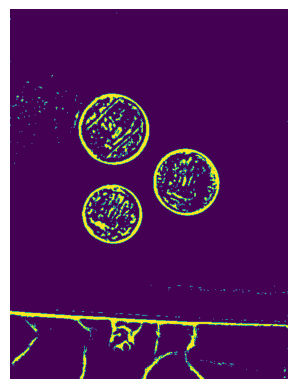

In [11]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
blurred = cv2.medianBlur(gray, 5)


thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 21, 3  # Experiment with values
)



plt.imshow(thresh)
plt.axis("off")
plt.show()



In [12]:
# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

coin_contours=[]

for cnt in contours:
    area = cv2.contourArea(cnt)
    
    # Ignore very small contours (noise) or very large ones (merged coins)
    if area < 500*(scale_factor**2):  
        continue
    
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    # Compute circularity (closer to 1 is better)
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    if 0.7 < circularity < 1.4:  # Allow some flexibility
        # Fit a circle around the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        coin_contours.append(cnt)

        # Draw detected circle and contour
        cv2.circle(image, center, radius, (0, 0, 255), 5)  # Red border
        cv2.drawContours(image, [cnt], -1, (0, 255, 0), 2)  # Green contour


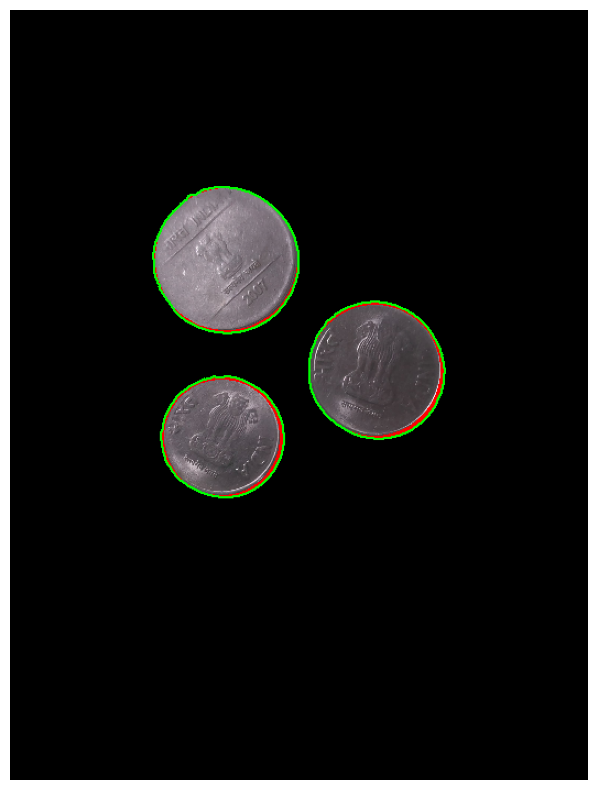

Saved detected_circles_black_bg.png


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create an empty mask
mask = np.zeros_like(image[:, :, 0])  # Single-channel mask

# Fill the detected coin contours with white (foreground)
cv2.drawContours(mask, coin_contours, -1, (255), thickness=cv2.FILLED)

# Apply the mask to the original image (keep only detected objects)
image_black_bg = cv2.bitwise_and(image, image, mask=mask)

# Save the image with a black background
cv2.imwrite("detected_circles_black_bg.png", image_black_bg)

# Show the image with black background
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_black_bg, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("Saved detected_circles_black_bg.png")


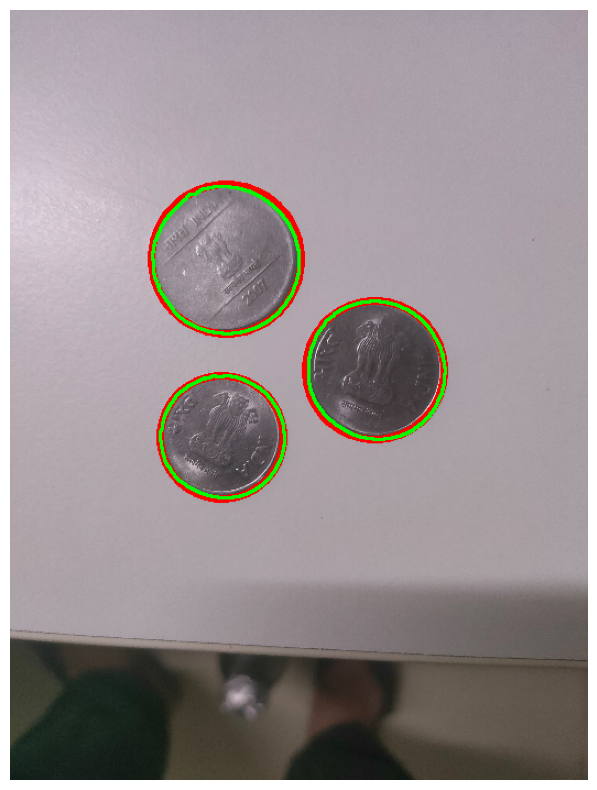

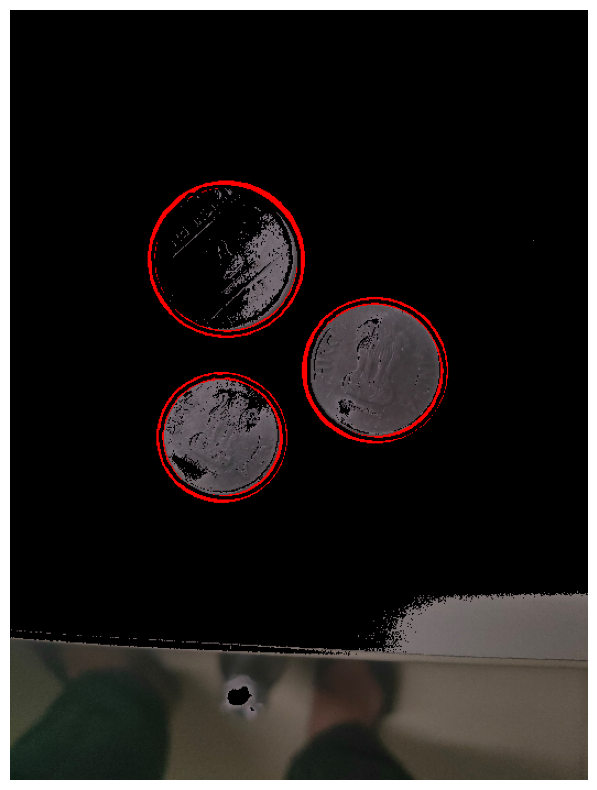

Saved detected_circles.png and detected_circles_black_bg.png


In [ ]:
# Convert BGR to RGB for visualization
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Save the RGB image
cv2.imwrite("detected_circles.png", cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving

# Show the image with detected circles
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

print("Saved detected_circles.png")


Saved coin_1.png


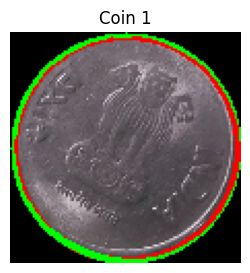

Saved coin_2.png


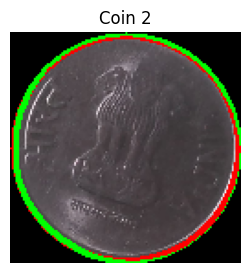

Saved coin_3.png


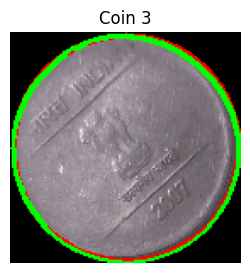

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

segmented_coins = []

for i, cnt in enumerate(coin_contours):
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    center = (int(x), int(y))
    radius = int(radius)
    
    # Ensure the bounding box stays within image bounds
    x1, y1 = max(center[0] - radius, 0), max(center[1] - radius, 0)
    x2, y2 = min(center[0] + radius, image.shape[1]), min(center[1] + radius, image.shape[0])

    # Create a mask for the coin
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    # Apply mask and crop the coin
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    coin_segment = masked_image[y1:y2, x1:x2]

    segmented_coins.append(coin_segment)

    # Save the segmented coin as an image
    filename = f"coin_{i+1}.png"
    cv2.imwrite(filename, coin_segment)
    print(f"Saved {filename}")

    # Show each segmented coin using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(coin_segment, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Coin {i+1}")
    plt.show()
